# Tutorial 7a: Frequentist hacker statistics

(c) 2016 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This exercise was generated from a Jupyter notebook.  You can download the notebook [here](t7a_hacker_stats.ipynb).*

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st
import numba

import corner
import bebi103

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
%matplotlib inline

In [lecture 6](http://bebi103.caltech.edu/2016/lecture_notes/l06_frequentist_methods.pdf), we talked about frequentist methods for parameter estimation and hypothesis testing leaning heavily on the procedure known as **bootstrapping**. In this tutorial, we will go over how we implement this in practice. We will work with some real data on the reproductive health of male bees that have been treated with pesticide.

## The data set

Neonicotinoid pesticides are thought to have inadvertent effects on service-providing insects such as bees. A recent study of this was recently [featured in the New York Times](http://www.nytimes.com/2016/07/29/science/neonicotinoid-insecticide-bee-sperm.html). The original paper is [Straub, et al.,  Proc. Royal Soc. B 283(1835): 20160506](http://dx.doi.org/10.1098/rspb.2016.0506). Straub and coworkers put their [data in the Dryad repository](http://dx.doi.org/10.5061/dryad.bs515), which means that it is free to all to work with!

(Do you see a trend here? If you want people to think deeply about your results, explore them, learn from them, in general further science with them, *make your data publicly available.* Strongly encourage the members of your lab to do the same.)

We will look at the sperm quality of drone bees using [this data set](../data/bee_sperm.csv). First, let's load in the data set and check it out.

In [2]:
df = pd.read_csv('../data/bee_sperm.csv', comment='#')
df.head()

,Specimen,Treatment,Environment,TreatmentNCSS,Sample ID,Colony,Cage,Sample,Sperm Volume per 500 ul,Quantity,ViabilityRaw (%),Quality,Age (d),Infertil,AliveSperm,Quantity Millions,Alive Sperm Millions,Dead Sperm Millions
0,227,Control,Cage,1,C2-1-1,2,1,1,2150000,2150000,96.7263814616756,96.726381,14,0,2079617,2.1500,2.079617,0.070383
1,228,Control,Cage,1,C2-1-2,2,1,2,2287500,2287500,96.3498079760595,96.349808,14,0,2204001,2.2875,2.204001,0.083499
2,229,Control,Cage,1,C2-1-3,2,1,3,87500,87500,98.75,98.750000,14,0,86406,0.0875,0.086406,0.001094
3,230,Control,Cage,1,C2-1-4,2,1,4,1875000,1875000,93.2874208336941,93.287421,14,0,1749139,1.8750,1.749139,0.125861
4,231,Control,Cage,1,C2-1-5,2,1,5,1587500,1587500,97.7925061050061,97.792506,14,0,1552456,1.5875,1.552456,0.035044


We are interested in the sperm **quality**, which is the fraction of sperm that are alive, and the **number of alive sperm**.  We'll start our analysis looking at the number of alive sperm. Let's first explore the data by making ECDFs for the two groups we will compare, those treated with pesticide ("Pesticide") and those that are not ("Control").

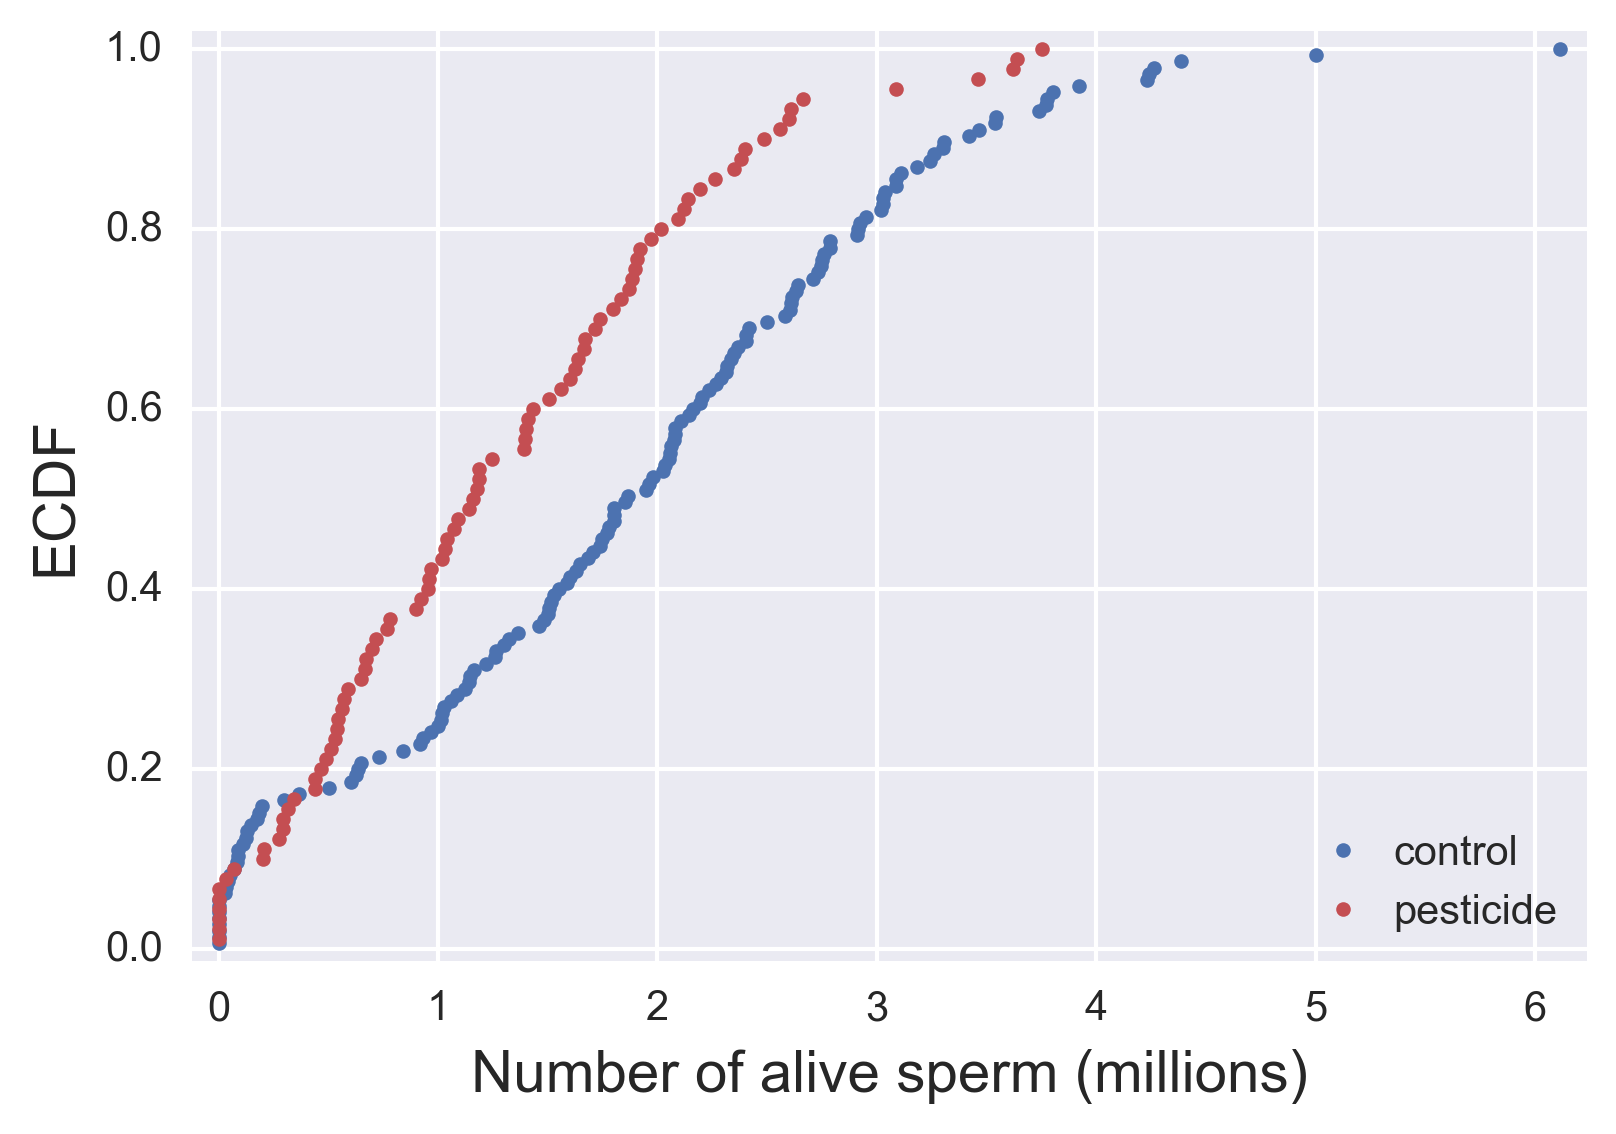

In [3]:
# Store data as Numpy arrays for speed later
alive_ctrl = df.loc[df['Treatment']=='Control', 
                          'Alive Sperm Millions'].values
alive_pest = df.loc[df['Treatment']=='Pesticide', 
                          'Alive Sperm Millions'].values

# Get x-y values for ECDF
x_control, y_control = bebi103.ecdf(alive_ctrl)
x_pest, y_pest = bebi103.ecdf(alive_pest)

# Make plots
plt.plot(x_control, y_control, marker='.', linestyle='none')
plt.plot(x_pest, y_pest, marker='.', linestyle='none', 
         color=sns.color_palette()[2])
plt.margins(0.02)
plt.xlabel('Number of alive sperm (millions)')
plt.ylabel('ECDF')
plt.legend(('control', 'pesticide'), loc='lower right');

The visual inspection of the ECDFs suggests that indeed the control drons have more alive sperm than those treated with pesticide. But how variable would these ECDFs be if we repeated the experiment?

## Bootstrap samples and ECDFs

To address this question, we can generate bootstrap samples from the experimental data and make lots of ECDFs. We can then plot them all to see how the ECDF might vary. Recall that a bootstrap sample from a data set of $n$ repeated measurements is generated by drawing $n$ data points out of the original data set with replacement. Let's write a utility function to do this.

In [4]:
@numba.jit(nopython=True)
def draw_bs_sample(data):
    """
    Draw a bootstrap sample from a 1D data set.
    """
    return np.random.choice(data, size=len(data))

That's a very simple function (and Numba-ing it does speed it up by almost a factor of 10), but it is still convenient to have. Let's use it to generate 100 bootstrap samples for each ECDF and plot them.

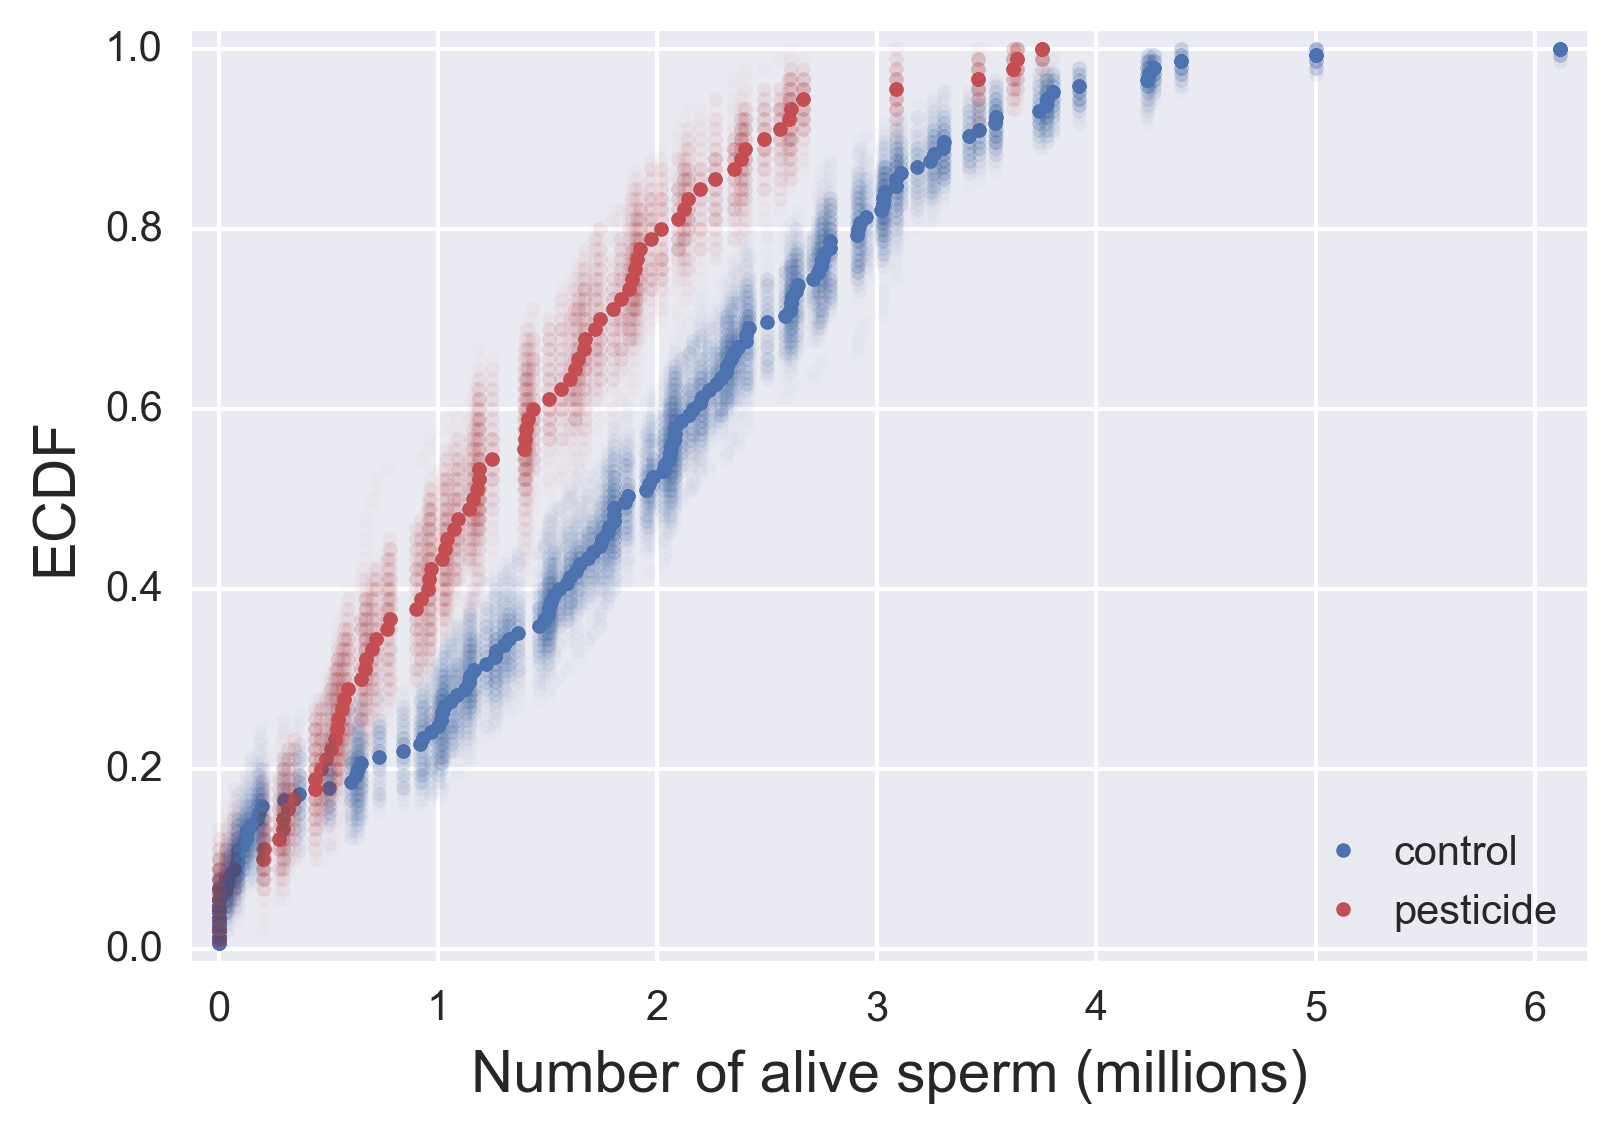

In [5]:
plt.plot(x_control, y_control, marker='.', linestyle='none')
plt.plot(x_pest, y_pest, marker='.', linestyle='none', 
         color=sns.color_palette()[2])

for _ in range(100):
    # Get x-y values for ECDF
    x_control, y_control = bebi103.ecdf(draw_bs_sample(alive_ctrl))
    x_pest, y_pest = bebi103.ecdf(draw_bs_sample(alive_pest))

    # Make plots
    plt.plot(x_control, y_control, marker='.', linestyle='none', alpha=0.02,
                color=sns.color_palette()[0])
    plt.plot(x_pest, y_pest, marker='.', linestyle='none', 
             color=sns.color_palette()[2], alpha=0.02)
plt.margins(0.02)
plt.xlabel('Number of alive sperm (millions)')
plt.ylabel('ECDF')
plt.legend(('control', 'pesticide'), loc='lower right');

From this graphical display, we can already see that the ECDFs do not overlap in 100 bootstrap samples, so there is likely a real difference between the two treatments.

## Bootstrap replicates and confidence intervals

We have plotted the ECDF of the data, which is instructive, but we would like to get estimates for properties of the ECDF. Remember, when doing nonparametric plug-in estimates, we plug in the ECDF for the CDF. We do not need to specify what the distribution (described mathematically by the CDF, or equivalently by the PDF) is, just that we approximate it by the empirical distribution.

In lecture, we laid out the procedure to compute a confidence interval.

1. Generate $B$ independent bootstrap samples.
2. Compute the statistic of interest for each bootstrap sample to get the **bootstrap replicates**.
3. The $100(1-\alpha)$ percent confidence interval consists of the percentiles $100\alpha/2$ and $100(1 - \alpha/2)$ of the bootstrap replicates.

A key step here is computing the bootstrap replicate. We will write a couple functions for this. The first is generic; it takes as an argument the function to be used to compute the statistic of interest (e.g., `np.mean` or `np.median`). We will also write a few functions for commonly computed statistics, which enables us to use Numba to greatly speed up the process of generating bootstrap replicates.

In [6]:
def draw_bs_reps(data, stat_fun, size=10000):
    """
    Draw boostrap replicates computed with stat_fun from 1D data set.
    """
    return np.array([stat_fun(draw_bs_sample(data)) for _ in range(size)])


@numba.jit(nopython=True)
def draw_bs_reps_mean(data, size=10000):
    """
    Draw boostrap replicates of the mean from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(data))
    return out


@numba.jit(nopython=True)
def draw_bs_reps_median(data, size=10000):
    """
    Draw boostrap replicates of the median from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.median(draw_bs_sample(data))
    return out

@numba.jit(nopython=True)
def draw_bs_reps_std(data, size=10000):
    """
    Draw boostrap replicates of the standard deviation from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.std(draw_bs_sample(data))
    return out

Just to show that it is worth it to Numba things, let's compare speed.

In [7]:
%timeit draw_bs_reps(alive_ctrl, np.mean)
%timeit draw_bs_reps_mean(alive_ctrl)

10 loops, best of 3: 92.5 ms per loop
The slowest run took 7.52 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 22.9 ms per loop


That's a four-fold speed boost; worth it.

Now, let's get bootstrap replicates for the mean of each of the two treatments.

In [8]:
bs_reps_mean_ctrl = draw_bs_reps_mean(alive_ctrl)
bs_reps_mean_pest = draw_bs_reps_mean(alive_pest)

We can now compute the confidence intervals by computing the percentiles using the `np.percentile()` function.

In [9]:
# 95% confidence intervals
mean_ctrl_conf_int = np.percentile(bs_reps_mean_ctrl, [2.5, 97.5])
mean_pest_conf_int = np.percentile(bs_reps_mean_pest, [2.5, 97.5])

print("""
Mean alive sperm count 95% conf int control (millions):   [{0:.2f}, {1:.2f}]
Mean alive sperm count 95% conf int treatment (millions): [{2:.2f}, {3:.2f}]
""".format(*(tuple(mean_ctrl_conf_int) + tuple(mean_pest_conf_int))))


Mean alive sperm count 95% conf int control (millions):   [1.67, 2.07]
Mean alive sperm count 95% conf int treatment (millions): [1.11, 1.49]



We can also use the bootstrap replicates to plot the probability distribution of mean alive sperm count. *Remember*: This is not a confidence interval on a parameter value. That does not make sense on frequentist statistics. It is the confidence interval describing what we would get as a plug-in estimate for the mean if we did the experiment over and over again.

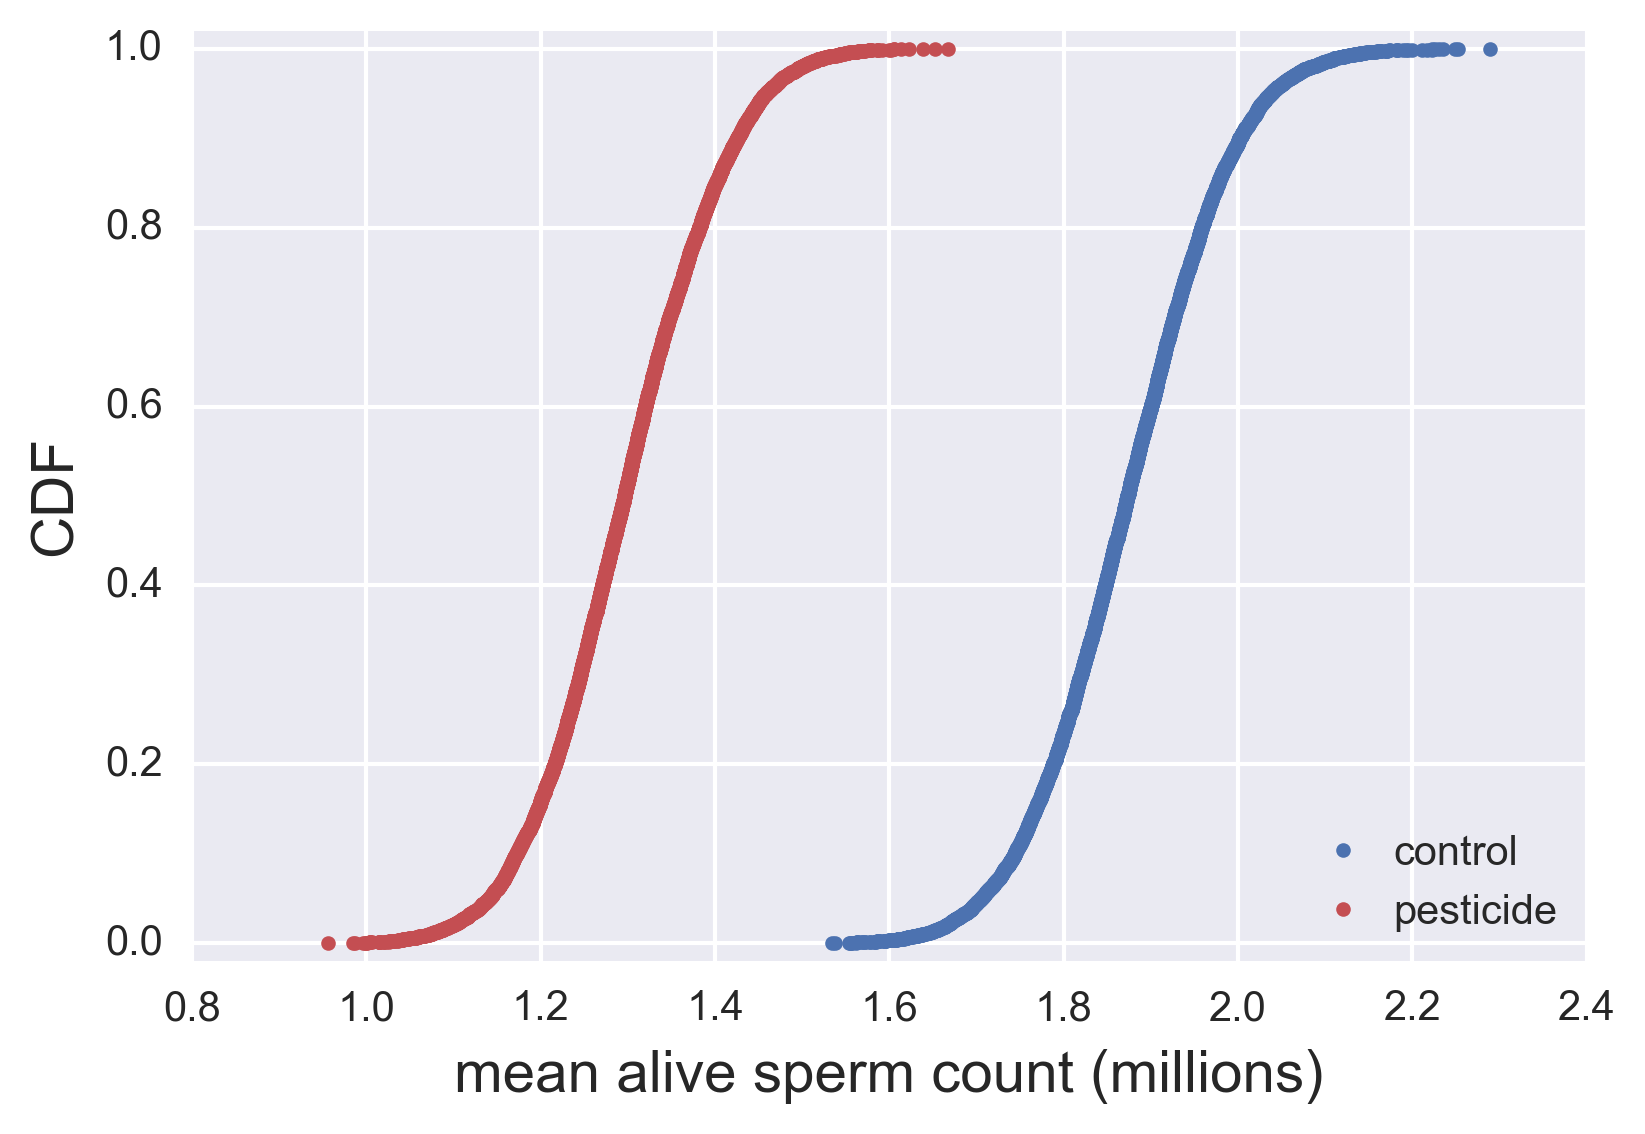

In [10]:
# Get ECDF points from bootstrap replicates
x_ctrl, y_ctrl = bebi103.ecdf(bs_reps_mean_ctrl)
x_pest, y_pest = bebi103.ecdf(bs_reps_mean_pest)

# Plot the ECDFs
plt.plot(x_ctrl, y_ctrl, '.', color=sns.color_palette()[0])
plt.plot(x_pest, y_pest, '.', color=sns.color_palette()[2])
plt.margins(y=0.02)
plt.xlabel('mean alive sperm count (millions)')
plt.ylabel('CDF')
plt.legend(('control', 'pesticide'), loc='lower right');

These are both nice, Gaussian distributions with just a little bit of overlap in the tails. This is expected, the mean alive sperm count should be Gaussian distributed as per the central limit theorem.

We can do the same procedure for other statistical quantities that do not follow the central limit theorem. The procedure is exactly the same. We will do it for the median.


Median alive sperm count 95% conf int control (millions):   [1.63, 2.11]
Median alive sperm count 95% conf int treatment (millions): [0.95, 1.47]



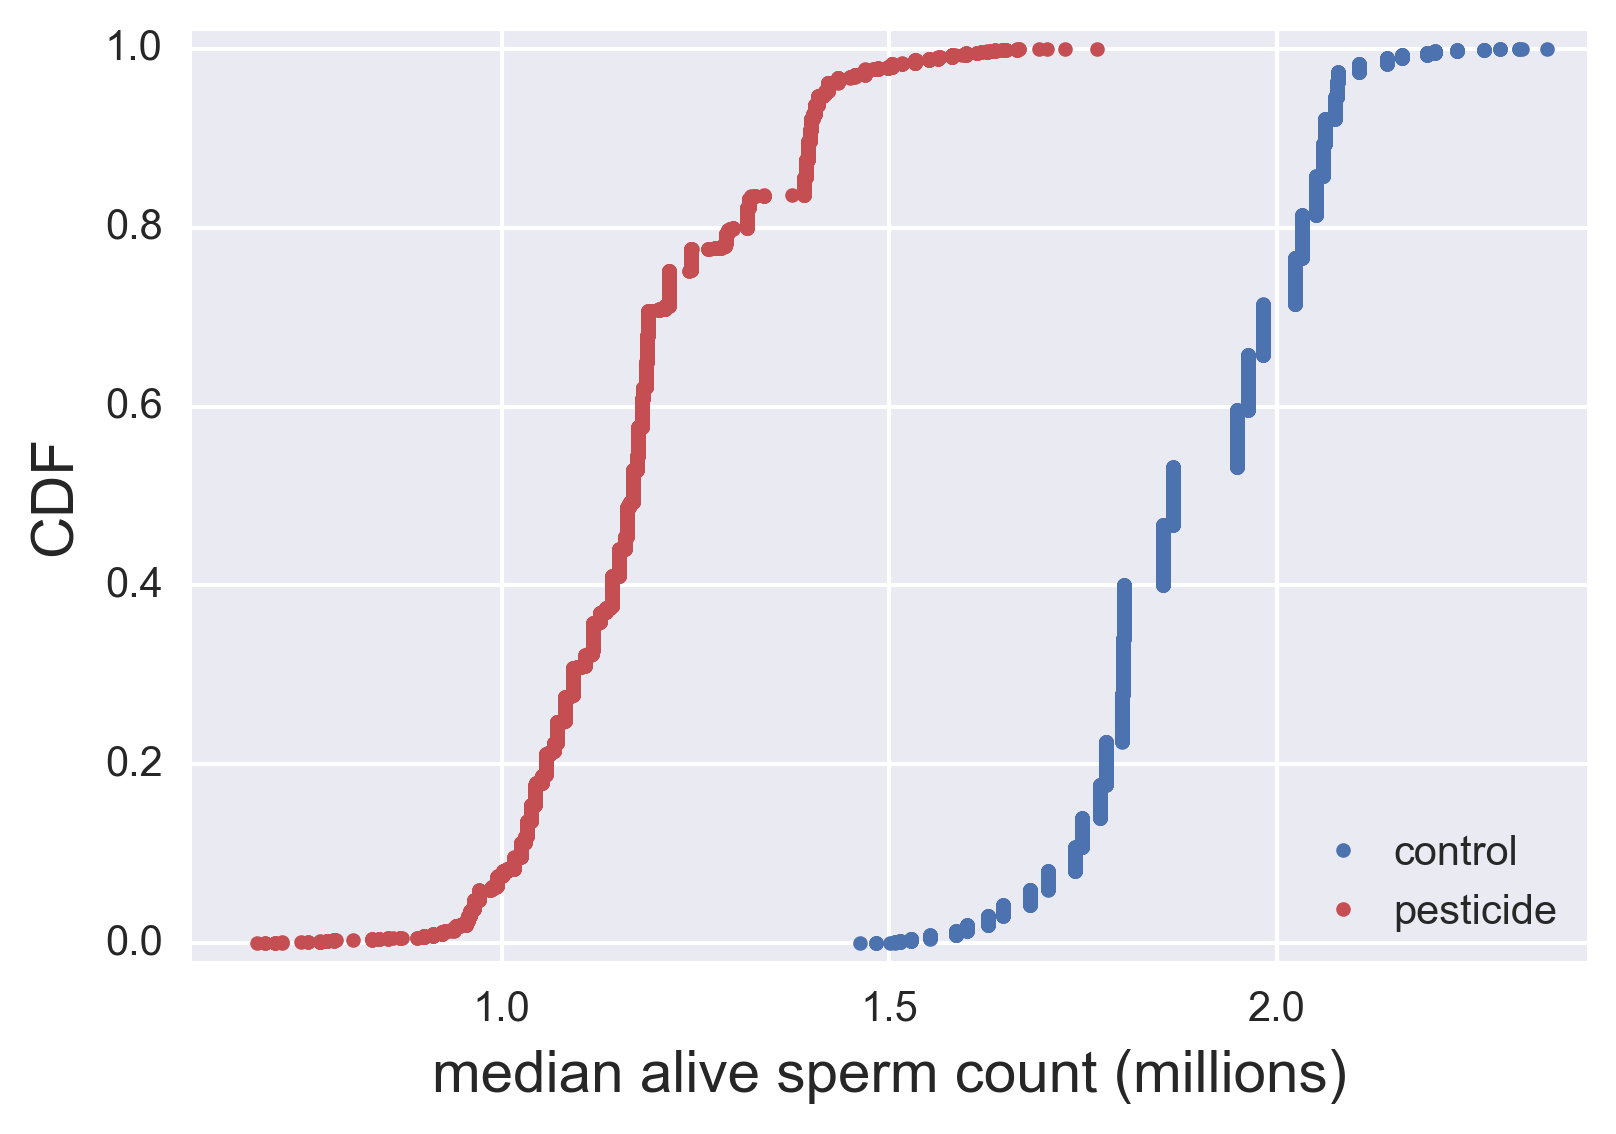

In [11]:
# Get the bootstrap replicates
bs_reps_median_ctrl = draw_bs_reps_median(alive_ctrl)
bs_reps_median_pest = draw_bs_reps_median(alive_pest)

# 95% confidence intervals
median_ctrl_conf_int = np.percentile(bs_reps_median_ctrl, [2.5, 97.5])
median_pest_conf_int = np.percentile(bs_reps_median_pest, [2.5, 97.5])

print("""
Median alive sperm count 95% conf int control (millions):   [{0:.2f}, {1:.2f}]
Median alive sperm count 95% conf int treatment (millions): [{2:.2f}, {3:.2f}]
""".format(*(tuple(median_ctrl_conf_int) + tuple(median_pest_conf_int))))

# Get ECDF points from bootstrap replicates
x_ctrl, y_ctrl = bebi103.ecdf(bs_reps_median_ctrl)
x_pest, y_pest = bebi103.ecdf(bs_reps_median_pest)

# Plot the ECDFs
plt.plot(x_ctrl, y_ctrl, '.', color=sns.color_palette()[0])
plt.plot(x_pest, y_pest, '.', color=sns.color_palette()[2])
plt.margins(y=0.02)
plt.xlabel('median alive sperm count (millions)')
plt.legend(('control', 'pesticide'), loc='lower right');
plt.ylabel('CDF');

The results are similar, and we clearly see nonGaussianity in the ECDFs.

## Pairs bootstrap and correlation

We might wish to investigate how two measured quantities are correlated. For example, if the number of dead sperm and the number of alive sperm are closely correlated, this would mean that a given drone produces some quantity of sperm and some fraction tend to be dead. Let's take a look at this.

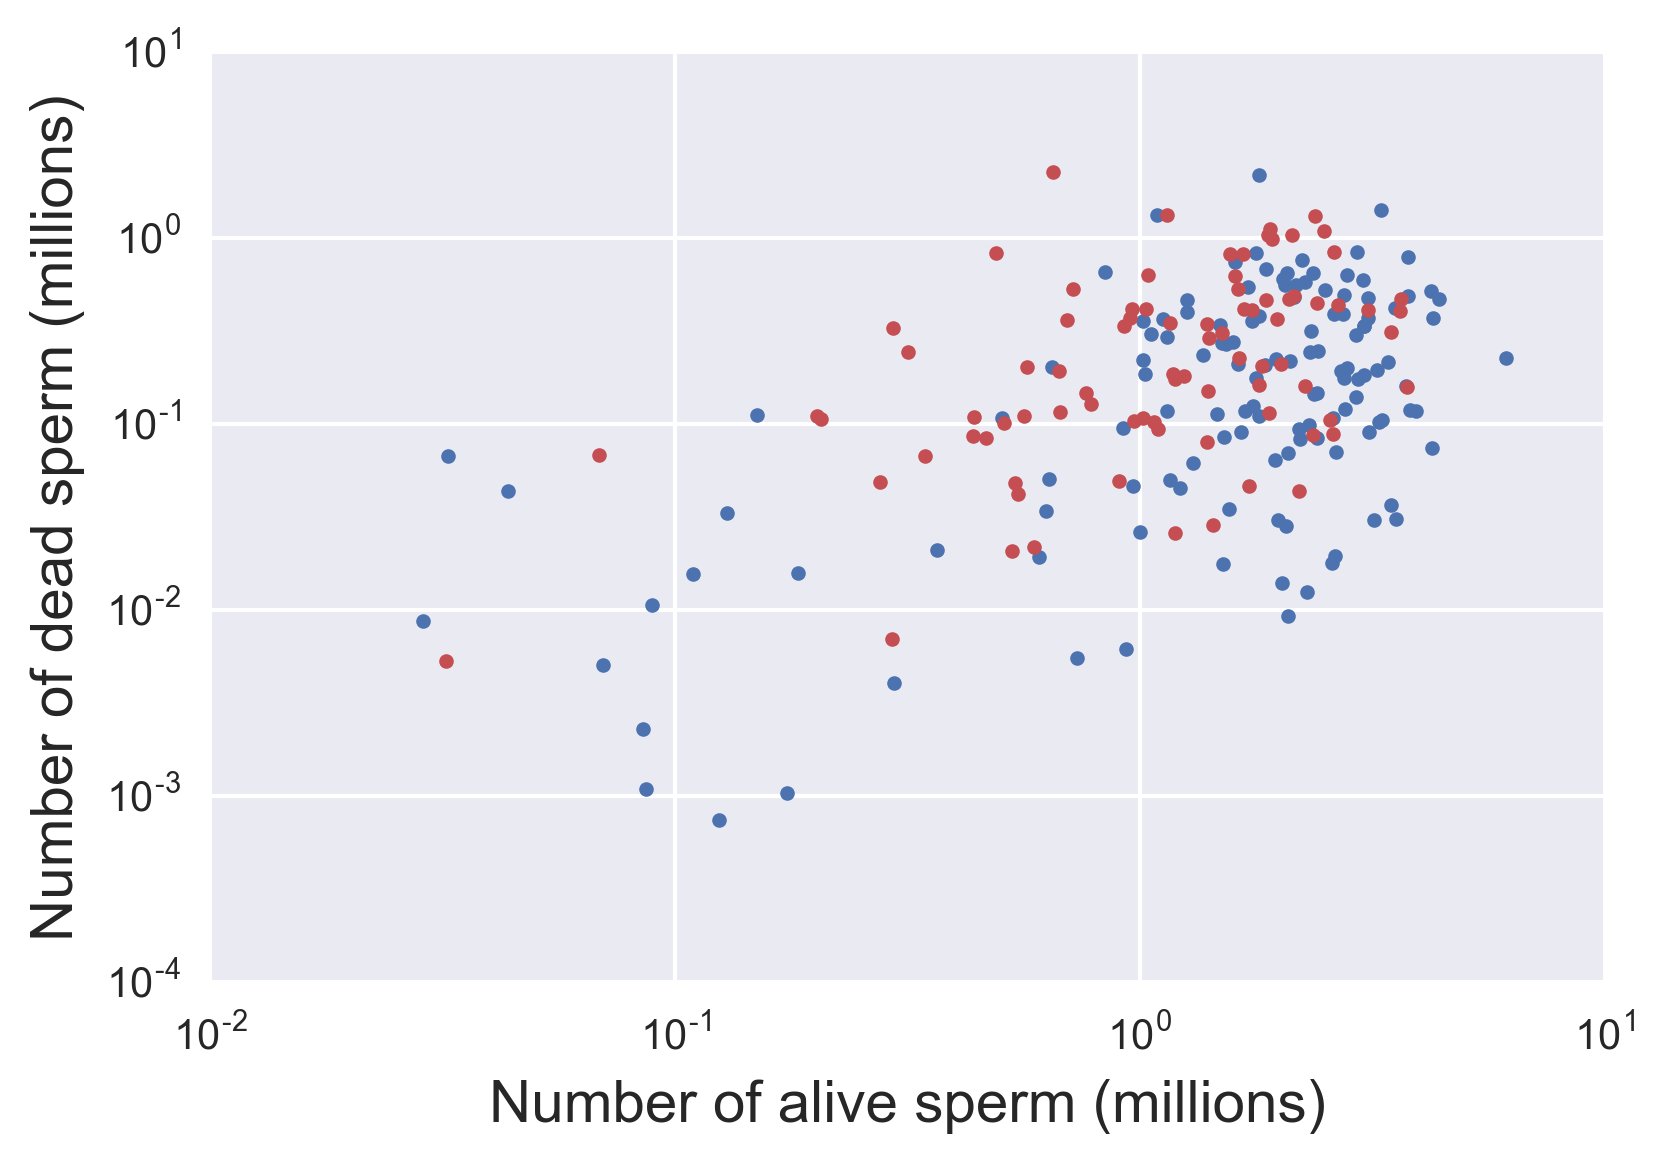

In [18]:
# Pull out data as Numpy arrays
dead_ctrl = df.loc[df.Treatment=='Control', 
                         'Dead Sperm Millions'].values
dead_pest = df.loc[df.Treatment=='Pesticide', 
                         'Dead Sperm Millions'].values

# Only keep non-zero entries
inds_ctrl = (alive_ctrl > 0) & (dead_ctrl > 0)
inds_pest = (alive_pest > 0) & (dead_pest > 0)

# Plot
plt.loglog(alive_ctrl[inds_ctrl], dead_ctrl[inds_ctrl], '.')
plt.loglog(alive_pest[inds_pest], dead_pest[inds_pest], '.', 
           color=sns.color_palette()[2])
plt.xlabel('Number of alive sperm (millions)')
plt.ylabel('Number of dead sperm (millions)');

There seems to be some correlation (on a log scale), but it is difficult to tell. We can compute the correlation with the **Pearson correlation coefficient**. This is the a measure of the covariance between variables (in this case alive and dead sperm) divided by the geometric mean of the individual variances and is implemented with `np.corrcoef()`,but we will code our own.

How can we get a confidence interval on a correlation coefficient? We can again apply the bootstrap, but this time, the replicate is a *pair* of data, in this case a dead sperm count/alive sperm count pair. Let's code that up.

In [19]:
@numba.jit(nopython=True)
def draw_bs_pairs(x, y):
    """
    Draw a pairs bootstrap sample.
    """
    inds = np.arange(len(x))
    bs_inds = draw_bs_sample(inds)
    return x[bs_inds], y[bs_inds]


@numba.jit(nopython=True)
def pearson_r(x, y):
    """
    Compute Pearson correlation coefficient.
    """
    return np.sum((x - np.mean(x)) * (y - np.mean(y))) / np.std(x) / np.std(y) \
                / np.sqrt(len(x)) / np.sqrt(len(y))

With our pairs samples, we can compute replicates.

In [20]:
@numba.jit(nopython=True)
def draw_bs_pairs_reps_pearson(x, y, size=10000):
    """
    Draw bootstrap pairs replicates.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = pearson_r(*draw_bs_pairs(x, y))
    return out

Finally, we can compute our confidence interval.

In [21]:
# Get reps
bs_reps_ctrl = draw_bs_pairs_reps_pearson(np.log(alive_ctrl[inds_ctrl]), 
                                          np.log(dead_ctrl[inds_ctrl]))
bs_reps_pest = draw_bs_pairs_reps_pearson(np.log(alive_pest[inds_pest]), 
                                          np.log(dead_pest[inds_pest]))

# Get the confidence intervals
conf_int_ctrl = np.percentile(bs_reps_ctrl, [2.5, 97.5])
conf_int_pest = np.percentile(bs_reps_pest, [2.5, 97.5])

print("""
Correlation in control conf int:   [{0:.2f}, {1:.2f}]
Correlation in pesticide conf int: [{2:.2f}, {3:.2f}]
""".format(*tuple(conf_int_ctrl), *tuple(conf_int_pest)))


Correlation in control conf int:   [0.44, 0.70]
Correlation in pesticide conf int: [0.28, 0.67]



We see a clear correlation in both samples, with a wide, but positive, confidence interval. Note that we did this analysis on a log scale, since the data span several orders of magnitude.

## Permutation hypothesis tests

We now venture into null hypothesis significance tests, or NHST. **Please carefully read the notes from [lecture 6](http://bebi103.caltech.edu/2016/lecture_notes/l06_frequentist_methods.pdf) to make sure you are very clear on what NHST is and what it entails.** It is *not* the same as Bayesian model selection.

Remember from lecture 6 the steps for performing an NHST.

1. Clearly state the null hypothesis.
2. Define a **test statistic**, a scalar value that you can compute from data. Compute it directly from your measured data.
3. *Simulate* data acquisition for the scenario where the null hypothesis is true. Do this many times, computing and storing the value of the test statistic each time.
4. The fraction of simulations for which the test statistic is at least as extreme as the test statistic computed from the measured data is called the **p-value**, which is what you report.

For one type of hypothesis, there is a very straight-forward way of simulating it. Here is our hypothesis: the control and pesticide-treated samples have exactly the same distribution. To simulate this, we take the following steps for two data sets, a control with $n$ measurements and a test the other with $m$.

1. Concatenate the two data sets into one.
2. Randomly scramble the order of the combined data set.
3. Designate the first $n$ entries in this scrambled array to be "control" and the remaining to be "test."

This simulation is exact; it is as if the label of the data set has no meaning; hence the distributions of the two data sets is entirely equal. We test such a null hypothesis with a **permutation test**. A **permutation sample** is akin to a bootstrap sample; it is a new pair of data sets generated after scrambling the concatenated data. A **permutation replicate** is a value of the test statistic computed from a permutation sample. Let's code this up.

In [22]:
@numba.jit(nopython=True)
def draw_perm_sample(x, y):
    """Generate a permutation sample."""
    concat_data = np.concatenate((x, y))
    np.random.shuffle(concat_data)
    return concat_data[:len(x)], concat_data[len(x):]


def draw_perm_reps(x, y, stat_fun, size=10000):
    """
    Generate array of permuation replicates.
    """
    return np.array([stat_fun(*draw_perm_sample(x, y)) for _ in range(size)])


@numba.jit(nopython=True)
def draw_perm_reps_diff_mean(x, y, size=10000):
    """
    Generate array of permuation replicates.
    """
    out = np.empty(size)
    for i in range(size):
        x_perm, y_perm = draw_perm_sample(x, y)
        out[i] = np.mean(x_perm) - np.mean(y_perm)
    return out

# Demonstrate Numba-ing is worth it.
%timeit draw_perm_reps(alive_ctrl, alive_pest, lambda x, y: np.mean(x) - np.mean(y))
%timeit draw_perm_reps_diff_mean(alive_ctrl, alive_pest)

1 loop, best of 3: 157 ms per loop
The slowest run took 6.37 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 28.8 ms per loop


To perform the hypothesis test, then, with the difference of means as our test statistic, we have only to draw many replicates and then tally up how many of them are more extreme than the observed difference of mean.

In [23]:
# Compute test statistic for original data set
diff_mean = np.mean(alive_ctrl) - np.mean(alive_pest)

# Draw replicates
perm_reps = draw_perm_reps_diff_mean(alive_ctrl, alive_pest, size=10000)

# Compute p-value
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value =', p_val)

p-value = 0.0


Whoa! Wait a minute. The p-value is *zero*? This just means that in all of the 10,000 replicates we too, not one had a test statistic as extreme as was observed. We cannot resolve p-values much less than 0.001 with 10,000 permutation replicated. Let's try taking ten million as see how we do. This will take about 30 seconds, as we saw from our timing.

In [24]:
# Compute test statistic for original data set
diff_mean = np.mean(alive_ctrl) - np.mean(alive_pest)

# Draw replicates
perm_reps = draw_perm_reps_diff_mean(alive_ctrl, alive_pest, size=10000000)

# Compute p-value
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value =', p_val)

p-value = 7.54e-05


So, our p-value is quite small, less than $10^{-4}$. This means that the probability of getting a difference of means as extreme as was observed under the null hypothesis that the control and test samples were drawn from identical distribution is quite small.

## Permutation hypothesis test for correlation

We might want to consider a hypothesis: dead and alive sperm counts are uncorrelated. It is possible that under this hypothesis, we could see correlation at the same level observed in the real data. We can test this hypothesis by permutation. In this case, we scramble the labels "dead" and "alive" and see what correlation we get.

In [29]:
# Compute Pearson r for actual data
r_ctrl = pearson_r(np.log(alive_ctrl[inds_ctrl]), np.log(dead_ctrl[inds_ctrl]))
r_pest = pearson_r(np.log(alive_pest[inds_pest]), np.log(dead_pest[inds_pest]))

# Get permutation replicates
perm_reps_ctrl = draw_perm_reps(np.log(alive_ctrl[inds_ctrl]), 
                                np.log(dead_ctrl[inds_ctrl]), 
                                pearson_r, size=10000000)
perm_reps_pest = draw_perm_reps(np.log(alive_pest[inds_pest]), 
                                np.log(dead_pest[inds_pest]), 
                                pearson_r, size=10000000)

# Compute p-value
p_ctrl = np.sum(np.abs(perm_reps_ctrl) > np.abs(r_ctrl)) / len(perm_reps_ctrl)
p_pest = np.sum(np.abs(perm_reps_pest) > np.abs(r_pest)) / len(perm_reps_pest)

print("""
p-value control:   {0:.3e}
p-value pesticide: {1:.3e}
""".format(p_ctrl, p_pest))


p-value control:   0.000e+00
p-value pesticide: 1.300e-06



Note that here we used the absolute value of the permutation replicates. We did this because we are interested to see if we get correlation at all, including anticorrelation. This is another essential piece of a hypothesis test: you need to define what it means to be more extreme. 

The p-value for both is tiny; not one in 10 million permutations for the control sample gave a correlation as high as was observed, and only 10 or so of the pesticide treated group.So, we would report something like $p < 10^{-6}$ for control and $p < 10^{-5}$ for pesticide.

## Bootstrap hypothesis tests

Permutation tests are great: they exactly simulate the null hypothesis. But, they are limited to a specific null hypothesis, that the two samples are identically distributed. What if we had a different hypothesis, say only that the means of the two distributions we are comparing are equal, but other properties of the distributions need not be identical? In this case, we cannot use the permutations to simulate the null hypothesis.

Instead, we can simulate the null hypothesis by *shifting* the means of the control and test distributions so that they are equal. We then take a bootstrap sample out of each of the shifted data sets. We compute our test statistic from these two bootstrap samples to get a bootstrap replicate. Then, the number of bootstrap replicates that are at least as extreme as the test statistic on the original data is used to compute the p-value. Let's see this in action. First, we'll see how to shift the data sets and what the resulting ECDFs look like.

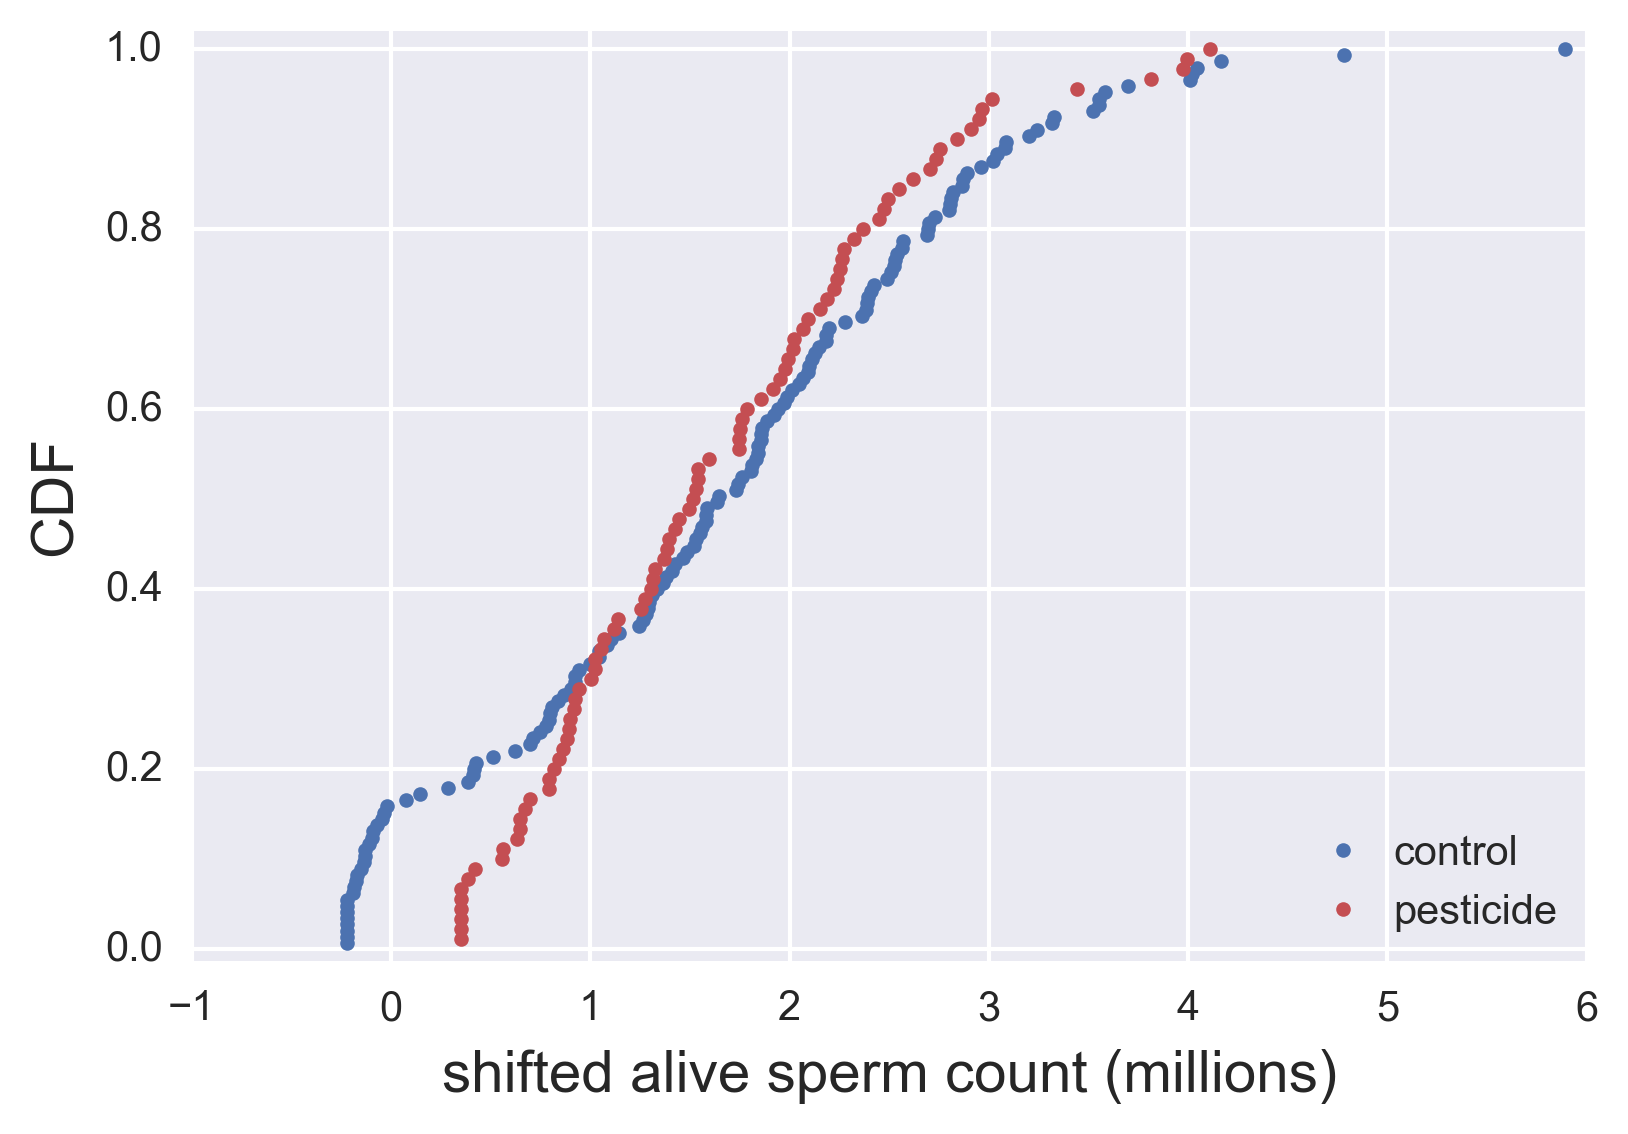

In [20]:
# Shift data sets
total_mean = np.mean(np.concatenate((alive_ctrl, alive_pest)))
alive_ctrl_shift = alive_ctrl - np.mean(alive_ctrl) + total_mean
alive_pest_shift = alive_pest - np.mean(alive_pest) + total_mean

# Plot the ECDFs
x_ctrl, y_ctrl = bebi103.ecdf(alive_ctrl_shift)
x_pest, y_pest = bebi103.ecdf(alive_pest_shift)

# Plot the ECDFs
plt.plot(x_ctrl, y_ctrl, '.', color=sns.color_palette()[0])
plt.plot(x_pest, y_pest, '.', color=sns.color_palette()[2])
plt.margins(y=0.02)
plt.xlabel('shifted alive sperm count (millions)')
plt.ylabel('CDF')
plt.legend(('control', 'pesticide'), loc='lower right');

The distributions now have the same mean, but nothing else about them has changed. They still have the same shape as before. Now, let's draw bootstrap samples out of these shifted distributions and see how they compare to the original ECDFs.

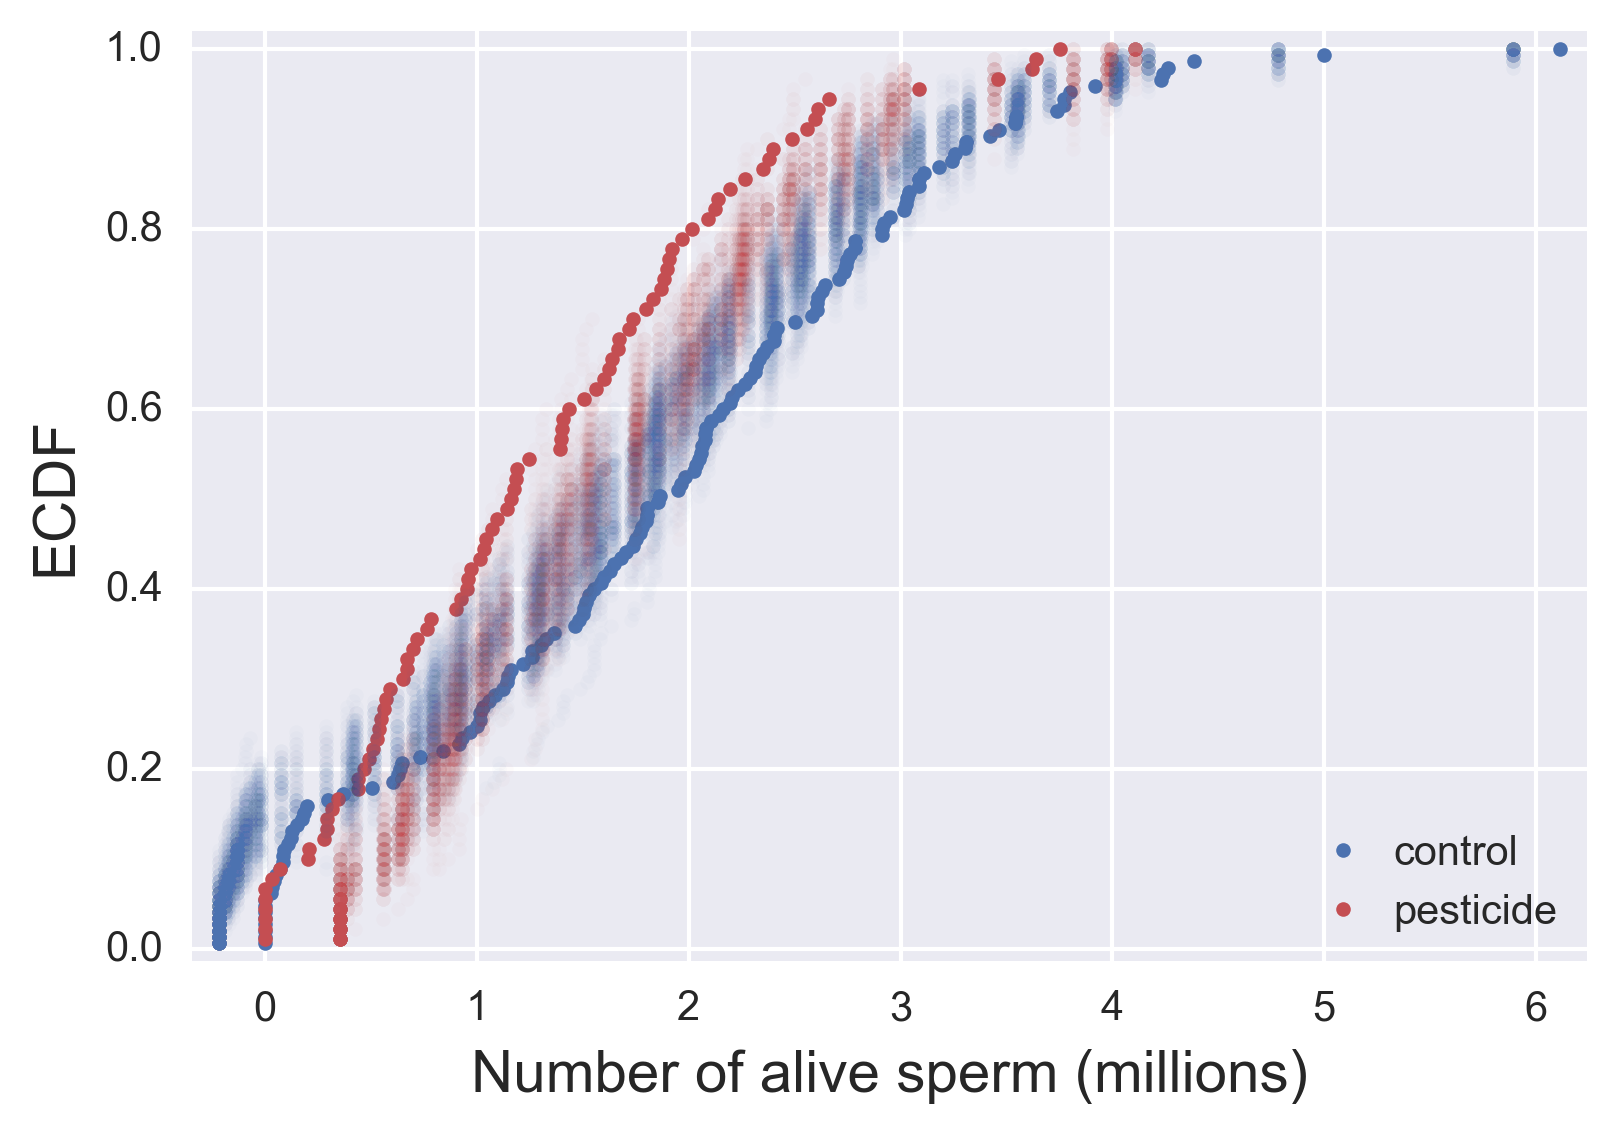

In [21]:
x_ctrl, y_ctrl = bebi103.ecdf(alive_ctrl)
x_pest, y_pest = bebi103.ecdf(alive_pest)
plt.plot(x_ctrl, y_ctrl, marker='.', linestyle='none')
plt.plot(x_pest, y_pest, marker='.', linestyle='none', 
         color=sns.color_palette()[2])

for _ in range(100):
    # Get x-y values for ECDF
    x_control, y_control = bebi103.ecdf(draw_bs_sample(alive_ctrl_shift))
    x_pest, y_pest = bebi103.ecdf(draw_bs_sample(alive_pest_shift))

    # Make plots
    plt.plot(x_control, y_control, marker='.', linestyle='none', alpha=0.02,
                color=sns.color_palette()[0])
    plt.plot(x_pest, y_pest, marker='.', linestyle='none', 
             color=sns.color_palette()[2], alpha=0.02)
plt.margins(0.02)
plt.xlabel('Number of alive sperm (millions)')
plt.ylabel('ECDF')
plt.legend(('control', 'pesticide'), loc='lower right');

The purple haze in between the ECDFs of the original data are the bootstrap samples under the null hypothesis. Only on rare occurrence does that haze reach the original ECDFs, so we might suspect that the observed data might not be all that probable under the null hypothesis. Let's perform the hypothesis test.

In [22]:
@numba.jit(nopython=True)
def draw_bs_reps_diff_mean(x, y, size=10000):
    """
    Generate bootstrap replicates with difference of means
    as the test statistic.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(x)) - np.mean(draw_bs_sample(y))
    return out

# Generate samples (10 million again)
bs_reps = draw_bs_reps_diff_mean(alive_ctrl_shift, alive_pest_shift, 
                                 size=10000000)

# Compute p-value
p_val = np.sum(bs_reps >= diff_mean) / len(bs_reps)

print('p-value =', p_val)

p-value = 1.85e-05


This p-value is of similar magnitude as what we got from the permutation test.

## Words of caution about NHST

There are lots of words of caution about null hypothesis significance tests. See [lecture 6](http://bebi103.caltech.edu/2016/lecture_notes/l06_frequentist_methods.pdf), again, for details. In the [next tutorial](t7b_dancing.html), we will see that p-values "dance" around. That is, they are not very reproducible statistics. You should be very very careful in your interpretation of them.